# Meme-stock Predictive Model Using Sentiment Analysis

Contributors: Yousif Alnuaimi, Oscar Alonso, Ricardo Gomez, Joanna Rashid



---
**Abstract**

Social media investment communities are having an appreciable effect on stock prices.  In this project, text analysis of Twitter, Reddit, and other social media post data is used to determine the stocks which are most frequently mentioned.  A polarity score assigned to each post using sentiment analysis is used to create a regression model to predict stock price.  

**Approach to the project**

Post data will be scrapped or downloaded from several social media groups or platforms with active investment communities (Twitter, Reddit, Discord, etc.).  Various natural language processing (NLP) packages will be tested to create a polarity time-series graph.  These packages may include NLTK, TextBlob, Syuzhet, Polyglot, CoreNLP, Gensim, and skLearn.  The package that produces a polarity curve most closely aligned to the daily stock price will be selected to generate post polarity scores.  To improve polarity score accuracy, a custom dictionary with investor-specific terms will be created.  A regression model (regressing polarity scores on stock price) will be used to predict the meme-stock’s price.  The model will be trained on previous meme stocks using 70-80% of post data.  The remaining data will be reserved to test the model.  Previous meme stocks used in this project will include but not be limited to GameStop, AMC, BlackBerry, TillRay, and Hertz.  We will consider other models such as SVM if linear regression does not prove accurate.
  

Current Project to do list as of 2/25/21: https://docs.google.com/document/d/1G0eaBwC6y2nl5YlFWXhW8jGyBD2FpUFEPzDbwOE5vFE/edit?usp=sharing





In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

#NLP
import nltk
from textblob import TextBlob
import textblob.classifiers
from nltk.tokenize import sent_tokenize
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')

from textblob.classifiers import NaiveBayesClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# WSB Preliminary Working Data

This is the test data on which the modeling was done.  Oscar and Joanna used this data to make and test predictive models.  In parallel Ricardo and Yousif procured and cleaned the larger data set seen in the next section.

In [ ]:
#data is hosted on github for ease of use of this notebook by multiple users
url = 'https://raw.githubusercontent.com/joannarashid/early_memestock_detect/main/reddit.csv'
df = pd.read_csv(url, sep = ',')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2925 entries, 0 to 2924
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         2925 non-null   object
 1   score         2925 non-null   int64 
 2   subreddit     2925 non-null   object
 3   url           2925 non-null   object
 4   num_comments  2925 non-null   int64 
 5   body          2076 non-null   object
 6   date          2925 non-null   object
dtypes: int64(2), object(5)
memory usage: 160.1+ KB


In [ ]:
df.head()

,title,score,subreddit,url,num_comments,body,date
0,UPVOTE so everyone sees we got SUPPORT,265029,wallstreetbets,https://i.redd.it/sgoqy8nyt2e61.png,11825,NaN,2021-01-29 00:40:34
1,GME YOLO update — Jan 28 2021,230844,wallstreetbets,https://i.redd.it/opzucppb15e61.png,23532,NaN,2021-01-29 08:06:23
2,CLASS ACTION AGAINST ROBINHOOD. Allowing peopl...,204920,wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,18318,LEAVE ROBINHOOD. They dont deserve to make mon...,2021-01-29 00:49:11
3,GME YOLO update — Jan 27 2021 ----------------...,185949,wallstreetbets,https://i.redd.it/a309gkm5yxd61.png,15495,NaN,2021-01-28 08:15:35
4,Can we all take a moment and appreciate the Mo...,184517,wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,7105,NaN,2021-01-28 11:57:32


In [ ]:
# Data Cleaning 
df['body'] = df['body'].astype(str) # converts the post body to strings
df['body'].str.lower() # converts the post body to lower case
df['title'] = df['title'].astype(str) # converts the post titles to strings
df['title'].str.lower() # converts the post titles to lower case

df['post'] = df['title'] + ' ' + df['body'] # combines the text in the title with the text body

df['timestamp'] = pd.to_datetime(df['date']) # converts timestamp into date/time format

df.drop(['date'], axis=1, inplace=True) #drop uneeded date column
df.drop(['subreddit'], axis=1, inplace=True) #drop uneeded column
df.drop(['url'], axis=1, inplace=True) #drop uneeded column

#Creates new colunmn from timestamp that contains only date - no time (useful for later joins)
df['date'] = df['timestamp'].dt.date

df.dropna() #drops all nulls and nans

,title,score,num_comments,body,post,timestamp,date
0,UPVOTE so everyone sees we got SUPPORT,265029,11825,nan,UPVOTE so everyone sees we got SUPPORT nan,2021-01-29 00:40:34,2021-01-29
1,GME YOLO update — Jan 28 2021,230844,23532,nan,GME YOLO update — Jan 28 2021 nan,2021-01-29 08:06:23,2021-01-29
2,CLASS ACTION AGAINST ROBINHOOD. Allowing peopl...,204920,18318,LEAVE ROBINHOOD. They dont deserve to make mon...,CLASS ACTION AGAINST ROBINHOOD. Allowing peopl...,2021-01-29 00:49:11,2021-01-29
3,GME YOLO update — Jan 27 2021 ----------------...,185949,15495,nan,GME YOLO update — Jan 27 2021 ----------------...,2021-01-28 08:15:35,2021-01-28
4,Can we all take a moment and appreciate the Mo...,184517,7105,nan,Can we all take a moment and appreciate the Mo...,2021-01-28 11:57:32,2021-01-28
...,...,...,...,...,...,...,...
2920,DID WE MISS THE BOTTOM?! How are people this i...,348,283,My mind is blown that so many people are convi...,DID WE MISS THE BOTTOM?! How are people this i...,2020-04-15 17:03:23,2020-04-15
2921,Favorite Solar Stock(s)?,348,176,"Hey there, I was wondering what everyone's pre...","Favorite Solar Stock(s)? Hey there, I was wond...",2020-11-02 10:46:49,2020-11-02
2922,"""NIO forms battery asset company""",352,102,"Nio has now launched ""baas"" they places over 1...","""NIO forms battery asset company"" Nio has now ...",2020-08-20 23:02:48,2020-08-20
2923,Amazon is building a $1.5 billion hub for its ...,349,145,Need another sign that Amazon is dead serious ...,Amazon is building a $1.5 billion hub for its ...,2017-02-02 03:35:04,2017-02-02


In [ ]:
# new df from orginal df filtering for mentions of GameStop
GME = ["GME", "$GME", "Gamestop", "gamestop"]
df_GME = df[df['post'].str.contains('GME')]

In [ ]:
df_GME.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 1 to 2858
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   title         160 non-null    object        
 1   score         160 non-null    int64         
 2   num_comments  160 non-null    int64         
 3   body          160 non-null    object        
 4   post          160 non-null    object        
 5   timestamp     160 non-null    datetime64[ns]
 6   date          160 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 10.0+ KB


## Most frequent words in WSB posts

used to scout common custom terms

In [ ]:
#new data frame with only the post text
df_words = df['post']

In [ ]:
#Cleaning data into a temporary variable
temp = df.post.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')

In [ ]:
# define punctuation
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

# remove punctuation from the  temporary string with all the post text
txt = ""
for char in temp:
   if char not in punctuations:
       txt = txt + char


In [ ]:
#tokenizing the works
all_words = nltk.tokenize.word_tokenize(txt)

#creating a frequency table
word_dist = nltk.FreqDist(all_words)

#eliminating stopwords
stopwords = nltk.corpus.stopwords.words('english')
words = nltk.FreqDist(w for w in all_words if w not in stopwords) 

In [ ]:
#creating new df with words and their relative frequency
df_common_words = pd.DataFrame(words.most_common(100),
                    columns=['Word', 'Frequency']).set_index('Word')

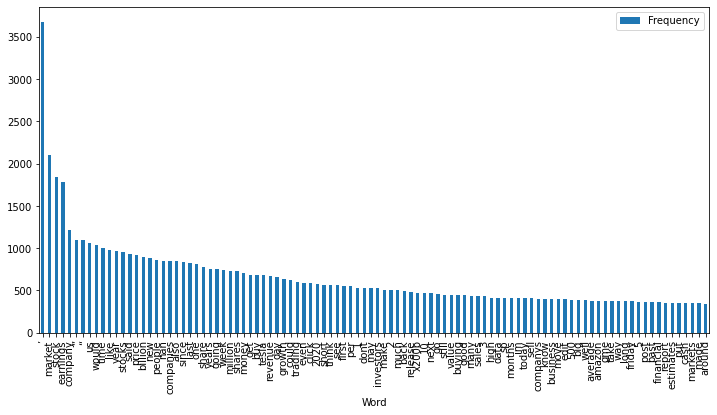

In [ ]:
#plotting most common word frequency
df_common_words.plot.bar(figsize=(12,6))

In [ ]:
#exporting most common words to explore in excel
df_common_words.to_csv("WSB_most_common_words")

### To Do: compare words against dictionary containing {ticker:name, name, name} to find companies mosty posted about.

# More WSB Data (Added 4/13/21)
## New dataframes: **wsb_df** & **wsb_extra_df**

New dataframes use datafiles from below.


1.   **wsb_df** contains: 'title', 'body', & 'timestamp'
2.   **wsb_extra_df** adds: lower case versions of title/body, word count for title/body, hashtags mentioned in title/body, & tickers mentioned in title/body 

Note:
- ticker mentioned has an issue where the function also extracts dollar amounts like $34289.32 etc.  

Permalinks to datafiles below:
- submissions_reddit-1.csv: https://raw.githubusercontent.com/gricardo831/Final-Project-Data/main/submissions_reddit_0.csv
- submissions_reddit-2.csv: https://raw.githubusercontent.com/gricardo831/Final-Project-Data/main/submissions_reddit_1.csv
- comments_2021-1-1_2021-11-29_new.csv: https://raw.githubusercontent.com/gricardo831/Final-Project-Data/main/comments_2021-1-1_2021-11-29_new.csv
- reddit_wsb.csv: https://raw.githubusercontent.com/gricardo831/Final-Project-Data/main/reddit_wsb.csv
- reddit.csv: https://raw.githubusercontent.com/gricardo831/Final-Project-Data/main/reddit.csv


In [ ]:
# Data 2: "submissions_reddit" data

# Github permalinks for Cloud use
submissions_reddit_1_url = 'https://raw.githubusercontent.com/gricardo831/Final-Project-Data/main/submissions_reddit_0.csv'
submissions_reddit_2_url = 'https://raw.githubusercontent.com/gricardo831/Final-Project-Data/main/submissions_reddit_1.csv'

# Creates dataframes for both, will have to combine into 1
df0a = pd.read_csv(submissions_reddit_1_url, sep=',')
df0b = pd.read_csv(submissions_reddit_2_url, sep=',', header=None)

# df0b has no column names, need to assign for easy merge
df0b.columns = ['id', 'author', 'created', 'retrieved', 'edited', 'pinned', 'archived', 'locked', 'removed',
                'deleted', 'is_self', 'is_video', 'is_original_content',
                'title', 'link_flair_text', 'upvote_ratio', 'score', 'gilded',
                'total_awards_received', 'num_comments', 'num_crossposts',
                'selftext', 'thumbnail', 'shortlink'] 

# Combines df0a and df0b into one dataframe data2
submissions_frames = [df0a, df0b]
data2 = pd.concat(submissions_frames)

# Data cleaning, converting data2 to a cleaned d2
data2.replace('[deleted]', np.nan, inplace =True)
d2 = data2[['title', 'selftext', 'created']]
d2.columns = ['title', 'body', 'timestamp'] # Renames columns

# Final df for Data 2. Ready for merge.
d2.head()

,title,body,timestamp
0,"3k - 170k since March (Also, buy LIT!!)",NaN,2021-01-01 00:02:06
1,Got out of PLTR calls after learning about IV ...,NaN,2021-01-01 00:03:20
2,Hell of a headline,NaN,2021-01-01 00:04:11
3,"Top popular stocks on WSB too! Also, why they ...",NaN,2021-01-01 00:11:51
4,WSBVoteBot Log for Jan 01 2021,Every time a new submission is posted to walls...,2021-01-01 00:15:38


In [ ]:
# Data 3: "comments_2021-1-1_2021-11-29_new" data

# Github permalink for Cloud use
comments_url = 'https://raw.githubusercontent.com/gricardo831/Final-Project-Data/main/comments_2021-1-1_2021-11-29_new.csv'

# Creates dataframe
data3 = pd.read_csv(comments_url, sep=',')

# Function for converting 10 digit time format into timestamp 
def time_conversion(time):
    return datetime.datetime.fromtimestamp(
        int(time)
    ).strftime('%Y-%m-%d %H:%M:%S')

# Apply time_conversion function to column 'Time', creating 'timestamp' column
data3['timestamp'] = data3['Time'].apply(lambda x: time_conversion(x))

# Creates data3_con which selects needed columns and renames them for consistency across dfs
data3_con = data3[['Body', 'timestamp']]
data3_con.columns = ['body', 'timestamp']

# Creates 'title' column with NaN values since original data contains comments only not full posts
data3_con['title'] = np.nan
d3 = data3_con[['title', 'body', 'timestamp']]

# Final df for Data 3. Ready for merge.
d3.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,title,body,timestamp
0,NaN,gay,2021-01-01 11:00:34
1,NaN,Daily discussion? About whattt,2021-01-01 11:01:05
2,NaN,PLTR 100 2022,2021-01-01 11:01:06
3,NaN,Twenty twenty won.,2021-01-01 11:01:53
4,NaN,"So Mark, how's your sex life?",2021-01-01 11:02:10


In [ ]:
# Data 4: "reddit_wsb" data

# Github permalink for Cloud use
reddit_wsb_url = 'https://raw.githubusercontent.com/gricardo831/Final-Project-Data/main/reddit_wsb.csv'

# Creates dataframe
data4 = pd.read_csv(reddit_wsb_url, sep=',')

# Selecting need columns to create d4
d4 = data4[['title', 'body', 'timestamp']]

# Final df for Data 4. Ready for merge.
d4.head()

,title,body,timestamp
0,"It's not about the money, it's about sending a...",NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,NaN,2021-01-28 21:32:10
2,Exit the system,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",NaN,2021-01-28 21:26:56


In [ ]:
# Data 5: "reddit" data

# Github permalink for Cloud use
reddit_url = 'https://raw.githubusercontent.com/gricardo831/Final-Project-Data/main/reddit.csv'

# Creates dataframe
data5 = pd.read_csv(reddit_url, sep=',')

# Narrows down dataframe to columns of interest
data5_wsb = data5[['title', 'subreddit', 'body', 'date']]

# Gets only rows with data from the 'wallstreetbets' subreddit
d5_wsb = data5_wsb[data5_wsb['subreddit'] == 'wallstreetbets'] # Extracts all rows with data from r/wallstreetbets

# Removes 'subreddit' column from selection for d5
d5 = d5_wsb[['title', 'body', 'date']]

# Renames columns in d5, replacing 'date' with 'timestamp'
d5.columns = ['title', 'body', 'timestamp']

# Final df for Data 5 Ready for merge.
d5.head()

,title,body,timestamp
0,UPVOTE so everyone sees we got SUPPORT,NaN,2021-01-29 00:40:34
1,GME YOLO update — Jan 28 2021,NaN,2021-01-29 08:06:23
2,CLASS ACTION AGAINST ROBINHOOD. Allowing peopl...,LEAVE ROBINHOOD. They dont deserve to make mon...,2021-01-29 00:49:11
3,GME YOLO update — Jan 27 2021 ----------------...,NaN,2021-01-28 08:15:35
4,Can we all take a moment and appreciate the Mo...,NaN,2021-01-28 11:57:32


In [ ]:
# Merging all dataframes into 1 (wsb_df).
wsb_df = d2.append([d3, d4, d5], ignore_index= True, sort= False)
# wsb_df

# Cleaning wsb_df

# Filling NaN values in 'title' and 'body' with "[empty]" values 
wsb_df['title'] = wsb_df['title'].fillna("[empty]")
wsb_df['body'] = wsb_df['body'].fillna("[empty]")

# Replacing "[removed]" values with "[empty]" values
wsb_df['title']=wsb_df['title'].replace({"[removed]":"[empty]"})
wsb_df['body'] = wsb_df['body'].replace({"[removed]":"[empty]"}) 

# Function for converting timestamp from string to numeric
from datetime import datetime

def stamp_conversion(time_string):
    datetimeObj = datetime.strptime(time_string, '%Y-%m-%d %H:%M:%S')
    return datetimeObj

# Applying function to 'timestamp' column
wsb_df['timestamp'] = wsb_df['timestamp'].apply(lambda x: stamp_conversion(x))

# Final cleaned dataframe for all data
wsb_df

,title,body,timestamp
0,"3k - 170k since March (Also, buy LIT!!)",[empty],2021-01-01 00:02:06
1,Got out of PLTR calls after learning about IV ...,[empty],2021-01-01 00:03:20
2,Hell of a headline,[empty],2021-01-01 00:04:11
3,"Top popular stocks on WSB too! Also, why they ...",[empty],2021-01-01 00:11:51
4,WSBVoteBot Log for Jan 01 2021,Every time a new submission is posted to walls...,2021-01-01 00:15:38
...,...,...,...
1071090,Its not Robinhood’s fault this time,[empty],2020-09-22 16:23:24
1071091,Robinhood be like...,[empty],2019-01-07 19:43:41
1071092,Paper hands can turn into diamond (credit to /...,[empty],2021-01-28 20:24:39
1071093,Boeing 737 runs over and kills a bear while la...,Boeing 737 ($BA) runs over and kills a ~~brown...,2020-11-16 22:14:17


In [ ]:
# Adding columns for different functions: lowercase title & body, word count title and body, hashtags & tickers

# Function for number of words in a string. Counts breaks in strings with spaces.
def word_count(string_words):
    word_list = string_words.split()
    number_of_words = len(word_list)
    return number_of_words

# Function for putting text in lower case.
def lower_words(string_words):
    lower_str = string_words.lower()
    return lower_str

# Function to extract hashtags from text in 'title' and 'body'
def extract_hashtags(title_text, body_text):
    hashtag_list = []                           # Initializing hashtag_list variable
    for word in title_text.split():             # Splitting the text into words
        if word[0] == '#':                      # Checking the first charcter of every word
            hashtag_list.append(word[1:])       # Adding the word to the hashtag_list
    for word in body_text.split():
        if word[0] == '#':
            hashtag_list.append(word[1:])
    for hashtag in hashtag_list:                # Returning the hashtag_list
        return hashtag

# Function to extract tickers from text in 'title' and 'body'
def extract_tickers(title_text, body_text):
    ticker_list = []
    dirty_list =[]
    for word in title_text.split():
        if word[0] == '$':
            dirty_list.append(word[1:])
            for item in dirty_list:
                if item.isnumeric() == False:
                    ticker_list.append(item)
    for word in body_text.split():
        if word[0] == '$':
            dirty_list.append(word[1:])
            for item in dirty_list:
                if item.isnumeric() == False:
                    ticker_list.append(item)
    for ticker in ticker_list:
        return ticker

In [ ]:
# New df for added columns
wsb_extra_df = wsb_df

# Applies lower_words function to 'title' and 'body' columns
wsb_extra_df['title_lower'] = wsb_extra_df['title'].apply(lambda x: lower_words(x))
wsb_extra_df['body_lower'] = wsb_extra_df['body'].apply(lambda x: lower_words(x))

# Applies word_count function to 'title' and 'body' columns
wsb_extra_df['title_word_count'] = wsb_extra_df['title'].apply(lambda x: word_count(x))
wsb_extra_df['body_word_count'] = wsb_extra_df['body'].apply(lambda x: word_count(x))

# Applies extract_tickers function to 'title' and 'body' columns
wsb_extra_df['tickers'] = wsb_extra_df.apply(lambda x: extract_tickers(x.title, x.body), axis =1)
# Applies extract_hashtags function to 'title' and 'body' columns
wsb_extra_df['hashtags'] = wsb_extra_df.apply(lambda x: extract_hashtags(x.title, x.body), axis=1)

wsb_extra_df

,title,body,timestamp,title_lower,body_lower,title_word_count,body_word_count,tickers,hashtags
0,"3k - 170k since March (Also, buy LIT!!)",[empty],2021-01-01 00:02:06,"3k - 170k since march (also, buy lit!!)",[empty],8,1,None,None
1,Got out of PLTR calls after learning about IV ...,[empty],2021-01-01 00:03:20,got out of pltr calls after learning about iv ...,[empty],36,1,None,None
2,Hell of a headline,[empty],2021-01-01 00:04:11,hell of a headline,[empty],4,1,None,None
3,"Top popular stocks on WSB too! Also, why they ...",[empty],2021-01-01 00:11:51,"top popular stocks on wsb too! also, why they ...",[empty],17,1,None,None
4,WSBVoteBot Log for Jan 01 2021,Every time a new submission is posted to walls...,2021-01-01 00:15:38,wsbvotebot log for jan 01 2021,every time a new submission is posted to walls...,6,66,None,None
...,...,...,...,...,...,...,...,...,...
1071090,Its not Robinhood’s fault this time,[empty],2020-09-22 16:23:24,its not robinhood’s fault this time,[empty],6,1,None,None
1071091,Robinhood be like...,[empty],2019-01-07 19:43:41,robinhood be like...,[empty],3,1,None,None
1071092,Paper hands can turn into diamond (credit to /...,[empty],2021-01-28 20:24:39,paper hands can turn into diamond (credit to /...,[empty],9,1,None,None
1071093,Boeing 737 runs over and kills a bear while la...,Boeing 737 ($BA) runs over and kills a ~~brown...,2020-11-16 22:14:17,boeing 737 runs over and kills a bear while la...,boeing 737 ($ba) runs over and kills a ~~brown...,21,137,None,None


In [ ]:
print(wsb_extra_df['timestamp'].max())

2021-03-12 07:12:33


In [ ]:
wsb_extra_df = wsb_extra_df.set_index('timestamp')

In [ ]:
wsb_extra_df.tail(100)

,title,body,title_lower,body_lower,title_word_count,body_word_count,tickers,hashtags
timestamp,,,,,,,,
2020-12-23 06:49:47,Welcome to story time,[empty],welcome to story time,[empty],4,1,None,None
2018-07-26 07:09:23,This deserves a repost,[empty],this deserves a repost,[empty],4,1,None,None
2020-12-04 19:42:36,I heard I can trade this in for internet points.,[empty],i heard i can trade this in for internet points.,[empty],10,1,None,None
2021-01-11 07:07:13,What half of the DDs posts sound like to me,[empty],what half of the dds posts sound like to me,[empty],10,1,None,None
2020-01-23 05:45:59,Tipanic,[empty],tipanic,[empty],1,1,None,None
...,...,...,...,...,...,...,...,...
2020-09-22 16:23:24,Its not Robinhood’s fault this time,[empty],its not robinhood’s fault this time,[empty],6,1,None,None
2019-01-07 19:43:41,Robinhood be like...,[empty],robinhood be like...,[empty],3,1,None,None
2021-01-28 20:24:39,Paper hands can turn into diamond (credit to /...,[empty],paper hands can turn into diamond (credit to /...,[empty],9,1,None,None


In [ ]:
wsb_extra_df.sort_index(ascending=False)
wsb_extra_df.tail()

,title,body,title_lower,body_lower,title_word_count,body_word_count,tickers,hashtags
timestamp,,,,,,,,
2020-09-22 16:23:24,Its not Robinhood’s fault this time,[empty],its not robinhood’s fault this time,[empty],6,1,None,None
2019-01-07 19:43:41,Robinhood be like...,[empty],robinhood be like...,[empty],3,1,None,None
2021-01-28 20:24:39,Paper hands can turn into diamond (credit to /...,[empty],paper hands can turn into diamond (credit to /...,[empty],9,1,None,None
2020-11-16 22:14:17,Boeing 737 runs over and kills a bear while la...,Boeing 737 ($BA) runs over and kills a ~~brown...,boeing 737 runs over and kills a bear while la...,boeing 737 ($ba) runs over and kills a ~~brown...,21,137,None,None
2020-11-30 20:32:01,Took a break from jacking off to check pre-mar...,[empty],took a break from jacking off to check pre-mar...,[empty],25,1,336K,None


In [ ]:
wsb_extra_df.shape

(1071095, 8)

In [ ]:
wsb_extra_df.to_csv(r'wsb_extra.csv')

# TextBlob Polarity and Subjectivity with TextBlob

In [ ]:
#gets the subjectivity score
def get_sub(text):
  return TextBlob(text).sentiment.subjectivity

#gets the polarity scrore
def get_pol(text):
  return TextBlob(text).sentiment.polarity

In [ ]:
# new column for subjectivity score of each post
df_GME['subjectivity'] = df_GME['post'].apply(get_sub)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# new column for polarity score of each post
df_GME['TB_polarity'] = df_GME['post'].apply(get_pol)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_GME.head()

,title,score,num_comments,body,post,timestamp,date,subjectivity,TB_polarity
1,GME YOLO update — Jan 28 2021,230844,23532,nan,GME YOLO update — Jan 28 2021 nan,2021-01-29 08:06:23,2021-01-29,0.000000,0.000000
2,CLASS ACTION AGAINST ROBINHOOD. Allowing peopl...,204920,18318,LEAVE ROBINHOOD. They dont deserve to make mon...,CLASS ACTION AGAINST ROBINHOOD. Allowing peopl...,2021-01-29 00:49:11,2021-01-29,0.432372,0.072596
3,GME YOLO update — Jan 27 2021 ----------------...,185949,15495,nan,GME YOLO update — Jan 27 2021 ----------------...,2021-01-28 08:15:35,2021-01-28,0.000000,0.000000
10,"AMERICANS CAN'T BUY GME, BB?!?! HELP IS ON THE...",157980,23210,Edit* Not just Canadians!! The whole world is ...,"AMERICANS CAN'T BUY GME, BB?!?! HELP IS ON THE...",2021-01-29 01:32:00,2021-01-29,0.300000,0.104167
15,"An Open Letter to Melvin Capital, CNBC, Boomer...",138569,7802,"**Mods do not delete, this is important to me...","An Open Letter to Melvin Capital, CNBC, Boomer...",2021-01-28 16:06:14,2021-01-28,0.526964,0.055682


In [ ]:
df_GME.head()

,title,score,num_comments,body,post,timestamp,date,subjectivity,TB_polarity
1,GME YOLO update — Jan 28 2021,230844,23532,nan,GME YOLO update — Jan 28 2021 nan,2021-01-29 08:06:23,2021-01-29,0.000000,0.000000
2,CLASS ACTION AGAINST ROBINHOOD. Allowing peopl...,204920,18318,LEAVE ROBINHOOD. They dont deserve to make mon...,CLASS ACTION AGAINST ROBINHOOD. Allowing peopl...,2021-01-29 00:49:11,2021-01-29,0.432372,0.072596
3,GME YOLO update — Jan 27 2021 ----------------...,185949,15495,nan,GME YOLO update — Jan 27 2021 ----------------...,2021-01-28 08:15:35,2021-01-28,0.000000,0.000000
10,"AMERICANS CAN'T BUY GME, BB?!?! HELP IS ON THE...",157980,23210,Edit* Not just Canadians!! The whole world is ...,"AMERICANS CAN'T BUY GME, BB?!?! HELP IS ON THE...",2021-01-29 01:32:00,2021-01-29,0.300000,0.104167
15,"An Open Letter to Melvin Capital, CNBC, Boomer...",138569,7802,"**Mods do not delete, this is important to me...","An Open Letter to Melvin Capital, CNBC, Boomer...",2021-01-28 16:06:14,2021-01-28,0.526964,0.055682


In [ ]:
#exporting for modeling in R
df_GME.to_csv(r'df_GME.csv', index = False)

# TextBlob NaiveBayesClassifier Polarity with Custom Term Classifier

Textblob documentation on classifiers https://textblob.readthedocs.io/en/dev/classifiers.html

### Creating sample of tokenized sentences (DO NOT RUN)

This is exported to excel and manually classified because of their highly specific language.

In [ ]:
df_GME_sample = df_GME[(df_GME['timestamp'] < '2021-01-27')]


In [ ]:
# selecting the thighest scoring 200 posts 
df_GME_sample = df_GME_sample.sort_values(['score'], ascending=False).head(200)

In [ ]:
#parsing senetences in each post and storing into one string
GME_sample = df_GME_sample['post'].str.cat(sep=', ')

In [ ]:
#tokenizing string in to sentences
sent_tokenize(GME_sample)

['GME YOLO update — Jan 22 2021 nan, GME YOLO update — Jan 25 2021 nan, Can I get a flair for buying GME at the literal top ($155.29)?',
 'nan, GME YOLO update — Jan 13 2021 nan, $500 Donation For Every $50 Increase in GME Price.',
 '$1000 Donation To St Jude So Far 💎🙌🚀 nan, Wallstreetsbets getting infiltrated by CCP?',
 'Everyone has just read a well done DD of u/notccpbot.',
 'I want to alarm you retards and the mods this is how propaganda infiltration works.',
 'The first one comes out of the blue and everyone likes the post without considering the guys hidden agenda.',
 'Watch the coming weeks another user claming "chinese citizenship" giving his perspective because we liked it.',
 'This is CCP (Chinese Communist Party) shit to have more influence over investors (users here underestimate how much influence this subreddit has).',
 '/u/iFinesseThePlug mentioned:\n\n* 4 month old account\n* 1 post in something called [r/GenZedong](https://www.reddit.com/r/GenZedong/)\n* Never commente

In [ ]:
#exporting tonkenized string of sample posts
text_file = open("GME_post_sample.txt", "w")
n = text_file.write(GME_sample)
text_file.close()

#in excel these sentences will be manual classified by our 
#team since they contain highly niche language 

# Polarity Viz

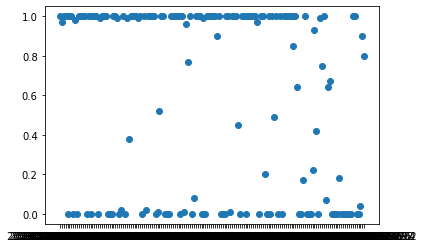

In [ ]:
#x and X for scatter plot
y = df_GME['NBC_polarity']
x = df_GME['date']

# Scatter plot NaiveBayesClassifier polarity scores over time (with custom terms)
#plt.figure(figsize=(12, 8))
plt.scatter(x, y)
plt.show()

Better! this scatter plot follow the stcok price pretty well.

Text(0, 0.5, 'mean polarity of posts')

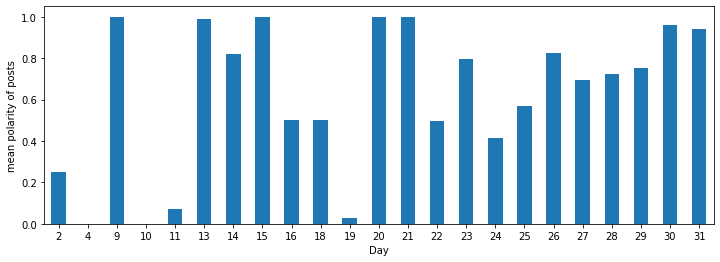

In [ ]:
#mean of polarity scores each day 
fig, axs = plt.subplots(figsize=(12, 4))
df_GME.groupby(df_GME['timestamp'].dt.day)['NBC_polarity'].mean().plot(
  kind='bar', rot=0, ax=axs),
plt.xlabel("Day"),
plt.ylabel("mean polarity of posts")


### Polarity with custom classifier

Importing manually classified sentences and using as polarity classifier

In [ ]:
#url = 'https://raw.githubusercontent.com/joannarashid/early_memestock_detect/b8e361f8612abb6c3075a75e49c995e492c57966/GME_post_train.csv'

In [ ]:
#import csv of manually rated posts as training set
with open('GME_post_train.csv', 'r') as fp:
  cl = NaiveBayesClassifier(fp, format="csv")

In [ ]:
#gets the polarity scrore
def NBC_pol(text):
  x = cl.prob_classify(text)
  return round(x.prob("pos"), 2)

In [ ]:
# new column for NaiveBayesClassifier polarity score of each post
df_GME['NBC_polarity'] = df_GME['post'].apply(NBC_pol)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#determine date of earliest post containing mention of GME
print("Earliest Post:", df_GME['date'].min())
print("Latest Post:", df_GME['date'].max())

KeyError: ignored

# GME Stock Price Data

In [ ]:
#Game stop stock data 2020-04-02 through 2021-01-29
#data is hosted on github for ease of use of this notebook by multiple users
url = 'https://raw.githubusercontent.com/joannarashid/early_memestock_detect/main/GME.csv'

df_gme_price = pd.read_csv(url, sep = ',')

In [ ]:
df_gme_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-02,3.26,3.35,2.85,2.85,2.85,4064300
1,2020-04-03,2.85,2.94,2.57,2.80,2.80,3830400
2,2020-04-06,2.86,3.20,2.83,3.09,3.09,3340500
3,2020-04-07,3.39,3.44,3.10,3.27,3.27,2836900
4,2020-04-08,3.23,3.67,3.20,3.41,3.41,2884500


In [ ]:
df_gme_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       208 non-null    object 
 1   Open       208 non-null    float64
 2   High       208 non-null    float64
 3   Low        208 non-null    float64
 4   Close      208 non-null    float64
 5   Adj Close  208 non-null    float64
 6   Volume     208 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 11.5+ KB


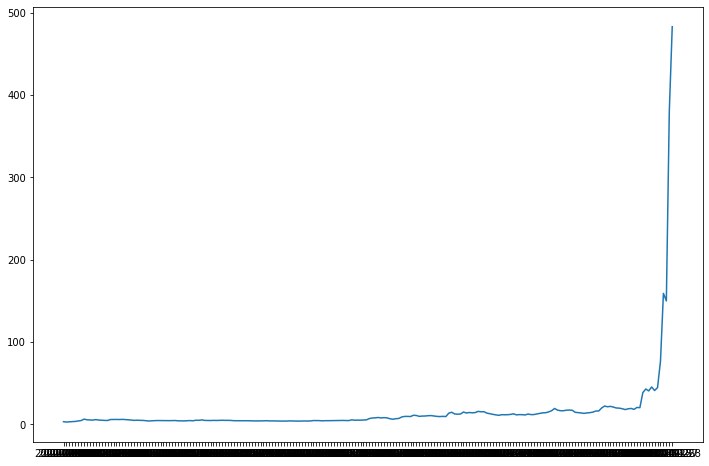

In [ ]:
#x and X for scatter plot
y = df_gme_price['High']
x = df_gme_price['Date']

# Scatter plot stock close price over time
plt.figure(figsize=(12, 8))
plt.plot(x, y)
plt.show()

# Predictive Modeling

Neural Network recomended by Professor:
https://scikit-learn.org/stable/modules/neural_networks_supervised.html 
(see 1.17.2. Classification and 1.17.3. Regression)

### Data cleaning for modeling

In [ ]:
import datetime

In [ ]:
# checking shape of both df's
df_pol_score = df_GME[['date', 'TB_polarity','score', 'num_comments', 'subjectivity', 'NBC_polarity']].copy()
df_gme_price = df_gme_price[['Date', 'Close']].copy()
print(df_pol_score.shape)
print(df_gme_price.shape)

KeyError: ignored

In [ ]:
# converting date to datetime
df_pol_score['date'] = pd.to_datetime(df_pol_score['date'])
df_gme_price['Date'] = pd.to_datetime(df_gme_price['Date'])

In [ ]:
# checking the range of both df's
print(df_pol_score['date'].min())
print(df_pol_score['date'].max())
print('')
print(df_gme_price['Date'].min())
print(df_gme_price['Date'].max())

2020-04-02 00:00:00
2021-01-29 00:00:00

2020-04-02 00:00:00
2021-01-28 00:00:00


In [ ]:
# combining both df's
df_clean = df_pol_score.merge(df_gme_price, how = 'left', left_on='date', right_on='Date') # Included "how ='left'" for merging on pol_score for each post rather than unique dates
df_clean.head()

,date,TB_polarity,score,num_comments,subjectivity,NBC_polarity,Date,Close
0,2021-01-29,0.000000,230844,23532,0.000000,1.00,NaT,NaN
1,2021-01-29,0.072596,204920,18318,0.432372,0.97,NaT,NaN
2,2021-01-28,0.000000,185949,15495,0.000000,1.00,2021-01-28,193.600006
3,2021-01-29,0.104167,157980,23210,0.300000,1.00,NaT,NaN
4,2021-01-28,0.055682,138569,7802,0.526964,0.00,2021-01-28,193.600006


In [ ]:
df_clean.drop('Date', axis=1, inplace=True)

In [ ]:
print(df_clean.shape) # 160 now!

(160, 7)


In [ ]:
# Organizing clean_df dataframe
df_clean = df_clean.sort_values(by='date', ascending= False, ignore_index=True) # Recent dates up top

# Missing values were all found on date 1/29/21. No data was collected in GME.csv. Replaced NaN with 325.00 found on YFinance for 1/29/21
df_clean['Close'].fillna(325.00, inplace=True) 
df_clean

,date,TB_polarity,score,num_comments,subjectivity,NBC_polarity,Close
0,2021-01-29,0.000000,230844,23532,0.000000,1.00,325.00
1,2021-01-29,-0.087877,18578,2159,0.506453,0.00,325.00
2,2021-01-29,0.033642,26702,1775,0.436728,0.07,325.00
3,2021-01-29,0.088393,41211,2311,0.438757,0.00,325.00
4,2021-01-29,0.247959,16512,971,0.597959,1.00,325.00
...,...,...,...,...,...,...,...
155,2020-11-16,0.004729,2011,625,0.526020,0.00,12.06
156,2020-10-13,0.157937,27420,1067,0.552381,0.02,11.88
157,2020-10-13,-0.061946,25102,513,0.589103,0.52,11.88
158,2020-10-09,0.000000,14480,1144,0.000000,1.00,12.02


IDK if this was what you were stuck on. Polarity and the close now correspond to their respective dates. There's a lot of repeats btw. This was also what I had trouble on during the time series. Hopefully this. is what you were looking for!

## Neural Network Regression (MPL Regressor)

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor

Testing a variety od variables in these model which include:

'TB_polarity' - TextBlob polarity. 
'score' - reddit score.    
'num_comments' - number of comments.    
'subjectivity' - subjectivity.   
'NBC_polarity' - polarity found with custom classifier. 

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

In [ ]:
#defining X variable
X = df_clean[['Date','TB_polarity','score', 'num_comments']]

#defining Y variable
y = df_clean['Close']

#spliting test and training sets
# X, y = make_regression(n_samples=200, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

NameError: ignored

In [ ]:
#train the model
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)

#predict
regr.predict(X_test[:4])


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array([288.24166765,   4.6611645 , 105.57054189,  64.3889317 ])

In [ ]:
#score
print("Neural Network Regression Model Accuracy: ", regr.score(X_test, y_test))

Neural Network Regression Model Accuracy:  -3.7085985862961515


Cannot achieve a good accuracy with any combination of variables.

Research on why: **Traditional nueral nets and ML algorithims are not well suited for timeseries data**

https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424

https://towardsdatascience.com/sktime-a-unified-python-library-for-time-series-machine-learning-3c103c139a55



## Neural Network MLPClassifier (in progress)

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier

Reading about this model suggests it is not actually suitable for timeseries.

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
#defining variables

X = df_clean[['TB_polarity','score', 'num_comments', 'subjectivity', 'NBC_polarity']].to_numpy() #converting to array

y = df_clean['Close'].to_numpy() # converting to array

In [ ]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                  hidden_layer_sizes=(3, 2), random_state=1)

clf.fit(X, y)

ValueError: ignored

## skTime Timeseries Clasifier (in progress)

https://www.sktime.org/en/latest/

This library uses the skLearn library but optimizes for timseries

In [ ]:
pip install sktime

     |████████████████████████████████| 5.7MB 4.5MB/s 
     |████████████████████████████████| 9.5MB 37.7MB/s 
     |████████████████████████████████| 22.3MB 1.7MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.dictionary_based import BOSSEnsemble
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.shapelet_based import MrSEQLClassifier
from sktime.datasets import load_basic_motions
from sktime.transformations.panel.compose import ColumnConcatenator

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
df_clean.set_index('Date')

,date,TB_polarity,score,num_comments,subjectivity,NBC_polarity,Close
Date,,,,,,,
2021-01-28,2021-01-28,0.000000,185949,15495,0.000000,1.00,193.600006
2021-01-28,2021-01-28,0.055682,138569,7802,0.526964,0.00,193.600006
2021-01-28,2021-01-28,0.000000,85278,4558,0.000000,0.98,193.600006
2021-01-28,2021-01-28,0.000000,81991,2773,0.000000,1.00,193.600006
2021-01-28,2021-01-28,-0.053501,44073,1956,0.681731,0.00,193.600006
...,...,...,...,...,...,...,...
2020-11-30,2020-11-30,0.000000,11099,796,0.000000,1.00,16.559999
2020-04-02,2020-04-02,-0.013636,1887,759,0.292740,0.22,2.850000
2020-11-16,2020-11-16,0.004729,2011,625,0.526020,0.00,12.060000


In [ ]:
#defining X variables
X = df_clean[['TB_polarity','score', 'num_comments', 'subjectivity', 'NBC_polarity']]

#defining Y variable stock closing price
y = df_clean['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(120, 5) (120,) (40, 5) (40,)


In [ ]:
np.unique(y_train)

array([  2.85    ,  11.88    ,  12.02    ,  12.06    ,  14.12    ,
        16.559999,  16.9     ,  18.84    ,  19.940001,  20.57    ,
        35.5     ,  39.119999,  39.360001,  39.91    ,  43.029999,
        65.010002,  76.790001, 147.979996, 193.600006, 325.      ,
       347.51001 ])

In [ ]:
#Column-wise ensembling via ColumnEnsembleClassifier 
#one classifier is fitted for each time series column and their predictions aggregated

clf = ColumnEnsembleClassifier(
    estimators=[
        ("TSF0", TimeSeriesForestClassifier(n_estimators=100), [0]),
        ("BOSSEnsemble3", BOSSEnsemble(max_ensemble_size=7), [3]),
    ]
)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

ValueError: ignored

In [ ]:
######TO DO#########
#need to make new df with nested series or arrays for this model to work

## ARIMA model (in progress)

In [ ]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Predictive Modeling with Aggrated Daily Data

In [ ]:
#importing aggregated data
df_agg = pd.read_csv("https://raw.githubusercontent.com/joannarashid/early_memestock_detect/main/df_agg.csv", sep = ',')

In [ ]:
df_agg['timestamp'] = pd.to_datetime(df['date']) # converts timestamp into date/time format
df_agg.dropna()

,Unnamed: 0,Date,TB_polarity,num_comments,score,subjectivity,Open,High,Low,Close,Adj.Close,Volume,timestamp
0,1,2020-04-02,-0.013636,759,1887,0.292740,3.260000,3.350000,2.850000,2.850000,2.850000,4064300.0,2021-01-29 00:40:34
1,2,2020-10-09,0.000000,1144,14480,0.000000,12.830000,14.800000,11.900000,12.020000,12.020000,77152800.0,2021-01-29 08:06:23
2,3,2020-10-13,0.095990,1580,52522,1.141484,11.730000,12.420000,11.650000,11.880000,11.880000,10179700.0,2021-01-29 00:49:11
3,4,2020-11-16,0.004729,625,2011,0.526020,11.160000,12.660000,10.720000,12.060000,12.060000,9774800.0,2021-01-28 08:15:35
4,5,2020-11-30,0.000000,796,11099,0.000000,18.170000,19.420000,16.559999,16.559999,16.559999,31983500.0,2021-01-28 11:57:32
5,6,2020-12-04,0.028579,475,1021,0.397678,16.299999,17.290001,16.260000,16.900000,16.900000,8972700.0,2021-01-29 12:35:58
6,7,2020-12-10,0.114336,254,441,0.463092,13.120000,14.410000,13.050000,14.120000,14.120000,7558900.0,2021-01-29 05:42:01
7,8,2020-12-23,0.149444,1247,12378,0.478333,20.170000,22.350000,19.129999,20.570000,20.570000,25830300.0,2021-01-29 08:47:55
8,9,2020-12-31,-0.246642,4516,21693,0.542336,19.250000,19.799999,18.799999,18.840000,18.840000,6922700.0,2021-01-28 08:55:22
9,10,2021-01-11,-0.047917,2655,41576,0.491667,19.410000,20.650000,19.010000,19.940001,19.940001,14927600.0,2021-01-29 08:33:21


In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

In [ ]:
#defining X variable
X = df_agg[['TB_polarity','score', 'num_comments']]

#defining Y variable
y = df_agg['Close']

#spliting test and training sets
# X, y = make_regression(n_samples=200, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
X

,TB_polarity,score,num_comments
0,-0.013636,1887,759
1,0.000000,14480,1144
2,0.095990,52522,1580
3,0.004729,2011,625
4,0.000000,11099,796
5,0.028579,1021,475
6,0.114336,441,254
7,0.149444,12378,1247
8,-0.246642,21693,4516
9,-0.047917,41576,2655


In [ ]:
#train the model
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)

#predict
regr.predict(X_test[:4])

ValueError: ignored

# Notes and References

*   
*   

